### **1. Introduction**

``Nama   : Banyu Nurmanjaya``

``Batch  : HCK-018``

Object : Membuat model clustering untuk melakukan ``Customer Segmentation`` dari data kartu kredit sebuah bank, datanya ini merupakan data informasi penggunaan kartu kredit selama 6 bulan terakhir.

### **2. Query SQL**

from google.colab import auth<br>
from google.cloud import bigquery<br>
auth.authenticate_user()<br>
print('Authenticated')<br>
project_id = "jovial-sprite-427108-i9" #GCP PROJECT-ID<br> 
client = bigquery.Client(project=project_id)

df = client.query('''<br>
SELECT * <br>
FROM `ftds-hacktiv8-project.phase1_ftds_018_hck.credit-card-information`<br>
WHERE MOD(CUST_ID, 2) = 0<br>
''').to_dataframe()

df.to_csv('P1G6_Set_1_banyu_nurmanjaya.csv')

#### **2.1. Dataset**

``Judul : Credit Card Information``

| Kolom | Tipe Data | Deskripsi |
| --- | --- | --- |
| CUST_ID | INT64 | identifikasi pemegang kartu kredit |
| BALANCE | FLOAT64 | jumlah saldo yang tersisa di akun mereka untuk melakukan pembelian |
| BALANCE_FREQUENCY | FLOAT64 | seberapa sering saldo diperbarui, nilai antara 0 dan 1 (1 = sering diperbarui, 0 = tidak sering diperbarui) |
| PURCHASES | FLOAT64 | jumlah pembelian yang dilakukan dari akun |
| ONEOFF_PURCHASES | FLOAT64 | jumlah pembelian maksimum yang dilakukan dalam sekali transaksi |
| INSTALLMENTS_PURCHASES | FLOAT64 | jumlah pembelian yang dilakukan dengan cicilan |
| CASH_ADVANCE | FLOAT64 | uang tunai di muka yang diberikan oleh pengguna |
| PURCHASES_FREQUENCY | FLOAT64 |  seberapa sering pembelian dilakukan, nilai antara 0 dan 1 (1=sering melakukan pembelian, 0=tidak sering melakukan pembelian) |
| ONEOFF_PURCHASES_FREQUENCY | FLOAT64 | seberapa sering pembelian dilakukan dalam sekali jalan (1 = sering, 0 = tidak sering) |
| PURCHASES_INSTALLMENTS_FREQUENCY | FLOAT64 |  seberapa sering pembelian dengan cicilan dilakukan (1=sering, 0=tidak sering) |
| CASH_ADVANCE_FREQUENCY | FLOAT64 | seberapa sering uang muka dibayarkan |
| CASH_ADVANCE_TRX | INT64 | jumlah transaksi yang dilakukan dengan 'uang muka' |
| PURCHASES_TRX | INT64 |  jumlah transaksi pembelian yang dilakukan |
| CREDIT_LIMIT | FLOAT64 |  batas kartu kredit untuk pengguna |
| PAYMENTS| FLOAT64 | jumlah pembayaran yang dilakukan oleh pengguna |
| MINIMUM_PAYMENTS | FLOAT64 | jumlah minimum pembayaran yang dilakukan oleh pengguna |
| PRC_FULL_PAYMENT | FLOAT64 | persentase pembayaran penuh yang dibayarkan oleh pengguna |
| TENURE | INT64 | jangka waktu layanan kartu kredit untuk pengguna |

### **3. Import Library**

In [211]:
# Library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm


### **4. Data Loading**

Proses ``mengambil data`` dari sumber asalnya dan memasukkannya ke dalam lingkungan analisis atau pemrosesan data

In [212]:
# Membaca file csv dengan variabel data
data = pd.read_csv('P1G6_Set_1_banyu_nurmanjaya.csv')

In [213]:
# Menampilkan 10 baris pertama
data.head(10)

Unnamed: 0  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  \
0           0      788    16.581535           0.125000      200.0   
1           1     1902   943.584041           0.875000      103.0   
2           2     2322     1.979916           0.125000       80.0   
3           3     3426   461.455720           1.000000      585.0   
4           4     3976  1053.594730           1.000000     1450.0   
5           5     4266  2237.238086           1.000000      120.0   
6           6     4360  2730.843802           1.000000     2900.0   
7           7     4680   424.994385           0.375000     1200.0   
8           8     5884    18.885677           0.375000       57.0   
9           9       24     0.004816           0.545455       51.7   

   ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
0               0.0                   200.0           0.0   
1             103.0                     0.0           0.0   
2              80.0                     0.0           0.0   
3             585.0                     0.0           0.0   
4            1450.0                     0.0           0.0   
5             120.0                     0.0           0.0   
6            2900.0                     0.0           0.0   
7            1200.0                     0.0           0.0   
8              57.0                     0.0           0.0   
9               0.0                    51.7           0.0   

   PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0                0.125                       0.000   
1                0.125                       0.125   
2                0.125                       0.125   
3                0.125                       0.125   
4                0.125                       0.125   
5                0.125                       0.125   
6                0.125                       0.125   
7                0.125                       0.125   
8                0.125                       0.125   
9                0.250                       0.000   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                             0.125                     0.0                 0   
1                             0.000                     0.0                 0   
2                             0.000                     0.0                 0   
3                             0.000                     0.0                 0   
4                             0.000                     0.0                 0   
5                             0.000                     0.0                 0   
6                             0.000                     0.0                 0   
7                             0.000                     0.0                 0   
8                             0.000                     0.0                 0   
9                             0.250                     0.0                 0   

   PURCHASES_TRX  CREDIT_LIMIT    PAYMENTS  MINIMUM_PAYMENTS  \
0              2        1200.0    0.000000               NaN   
1              1        1000.0  215.325023        410.484825   
2              1        1500.0    0.000000               NaN   
3              1        1000.0  258.032630        151.696433   
4              1        1500.0  397.090516        227.143184   
5              1        2500.0  343.102984        712.986387   
6              1        2900.0    0.000000               NaN   
7              1        1200.0   57.266292         56.720210   
8              1        1500.0    0.000000               NaN   
9              3        3000.0   33.249088          0.059481   

   PRC_FULL_PAYMENT  TENURE  
0               0.0       8  
1               0.0       8  
2               0.0       8  
3               0.0       8  
4               0.0       8  
5               0.0       8  
6               0.0       8  
7               0.0       8  
8               0.0       8  
9               0.0      12

In [214]:
# Menampilkan 10 baris terakhir
data.tail(10)

Unnamed: 0  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  \
4465        4465     1588   538.768762           0.909091     226.95   
4466        4466     6900  7468.012010           1.000000    1569.41   
4467        4467     2528   427.642111           0.888889       0.00   
4468        4468     1226   706.327578           0.888889     169.54   
4469        4469     2152  1420.727073           1.000000       0.00   
4470        4470     4630  1079.008102           1.000000       0.00   
4471        4471     8614   809.582978           0.909091       0.00   
4472        4472     4296  3386.490883           1.000000     560.98   
4473        4473     4476  4840.545574           1.000000    1595.93   
4474        4474     3564  1977.007090           1.000000    1032.04   

      ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
4465            129.58                   97.37    452.009130   
4466            796.07                  773.34   4500.288676   
4467              0.00                    0.00   2563.705644   
4468            169.54                    0.00   1406.735573   
4469              0.00                    0.00    311.804499   
4470              0.00                    0.00   1259.571764   
4471              0.00                    0.00   3819.672466   
4472            427.22                  133.76   2008.153534   
4473           1595.93                    0.00   4359.325750   
4474            226.90                  805.14   4335.919227   

      PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
4465             0.545455                    0.090909   
4466             0.545455                    0.454545   
4467             0.000000                    0.000000   
4468             0.333333                    0.333333   
4469             0.000000                    0.000000   
4470             0.000000                    0.000000   
4471             0.000000                    0.000000   
4472             1.000000                    0.727273   
4473             0.454545                    0.454545   
4474             0.909091                    0.090909   

      PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
4465                          0.454545                0.272727   
4466                          0.363636                0.272727   
4467                          0.000000                0.888889   
4468                          0.000000                0.888889   
4469                          0.000000                0.900000   
4470                          0.000000                0.545455   
4471                          0.000000                0.545455   
4472                          0.363636                0.545455   
4473                          0.000000                0.545455   
4474                          0.818182                0.545455   

      CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT     PAYMENTS  \
4465                 8              9        1200.0   946.649324   
4466                 7             10        8700.0  2162.943350   
4467                62              0        1200.0  2853.967334   
4468                14              3        2500.0   302.976780   
4469                 9              0        1500.0   506.765033   
4470                 9              0        1200.0  1379.635287   
4471                 7              0        4150.0  4372.148648   
4472                 9             20       10100.0  1039.000037   
4473                17             25        6000.0   905.844846   
4474                21             17        4000.0  3056.424974   

      MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465        211.220001          0.000000      11  
4466       4628.802111          0.000000      11  
4467        146.976542          0.500000       9  
4468        142.597254          0.000000       9  
4469        449.179818          0.000000      10  
4470        271.364415          0.090909      11  
4471        241.645387          0.090909      1

In [215]:
# Menampilkan informasi dari dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        4475 non-null   int64  
 1   CUST_ID                           4475 non-null   int64  
 2   BALANCE                           4475 non-null   float64
 3   BALANCE_FREQUENCY                 4475 non-null   float64
 4   PURCHASES                         4475 non-null   float64
 5   ONEOFF_PURCHASES                  4475 non-null   float64
 6   INSTALLMENTS_PURCHASES            4475 non-null   float64
 7   CASH_ADVANCE                      4475 non-null   float64
 8   PURCHASES_FREQUENCY               4475 non-null   float64
 9   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 10  PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 11  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 12  CASH_A

**Informasi:**

* Total kolom ``(19)``
* Total baris ``(4475)``
* Semua memiliki tipe data ``float,`` kecuali ``CUST_ID, CASH_ADVANCE_TRX, PURCHASES_TRX`` yang mana itu merupakan tipe data ``integer``
* Terdapat ``data duplikat``
* Terdapat ``missing value``
* Kolom ``Unnamed: 0`` biasanya merupakan ``indeks otomatis`` yang ditambahkan oleh pandas saat membaca data dari file CSV 

In [216]:
# Hapus kolom 'Unnamed: 0'
data = data.drop('Unnamed: 0', axis=1)

Biasanya, kolom ini ``tidak mengandung informasi yang relevan`` untuk analisis data, untuk itu, sering dihapus sebelum melakukan analisis lebih lanjut lagi

In [217]:
# Melihat semua kolom terbaru
data.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [218]:
# Melihat jumlah data duplikat
print("Jumlah Data Duplikat: ", data.duplicated().sum())

Jumlah Data Duplikat:  0


In [219]:
# Menghapus data yang memiliki duplikat
data.drop_duplicates(inplace=True)

In [220]:
# Melihat kembali jumlah data duplikat
print("Jumlah Data Duplikat: ", data.duplicated().sum())

Jumlah Data Duplikat:  0


Data duplikat dihapus karena ``bisa memengaruhi akurasi analisis dan menyulitkan interpretasi,`` seperti: membuat analisis menjadi lebih sulit dan membingungkan, terutama jika data duplikat tidak mudah diidentifikasi

### **5. Exploratory Data Analysis I (EDA I)**

In [221]:
# Menyalin dataframe
data_viz = data.copy()

Menyalin DataFrame dengan tujuan untuk ``melindungi data asli`` yang mana bisa mencegah perubahan tak sengaja

In [222]:
# Menampikan dataframe yang sudah di salin
data_viz.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535              0.125      200.0               0.0   
1     1902   943.584041              0.875      103.0             103.0   
2     2322     1.979916              0.125       80.0              80.0   
3     3426   461.455720              1.000      585.0             585.0   
4     3976  1053.594730              1.000     1450.0            1450.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000               NaN               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000               NaN               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8

#### **5.1. Customer Balance Distribution**

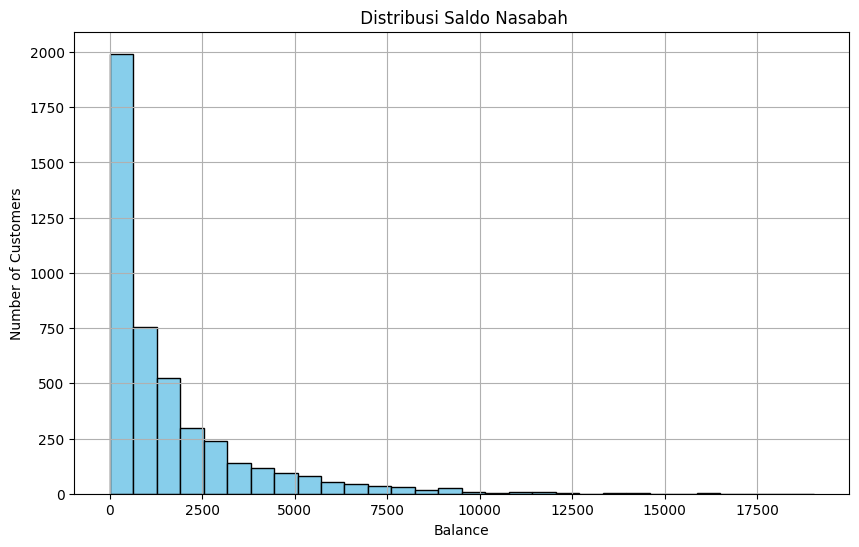

In [287]:
# Distribusi Saldo Nasabah
plt.figure(figsize=(10, 6))
data_viz['BALANCE'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Customer Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

**Insight:**

1. **Sebagian besar nasabah memiliki saldo yang relatif rendah:**
Terlihat jelas sebagian besar nasabah memiliki saldo di bawah 5.000

2. **Distribusi yang Skew ke Kanan:**
Grafik ini juga menunjukkan ``distribusi yang skewed to the right atau miring ke kanan.`` Artinya, terdapat sedikit nasabah dengan saldo yang sangat tinggi, tetapi jumlah nasabah dengan saldo rendah jauh lebih banyak

**Implikasi:**
 Memahami distribusi dari saldo ini ``dapat membantu lembaga keuangan dalam merancang strategi pemasaran`` yang lebih efektif. Seperti, untuk nasabah dengan saldo rendah, bisa ditawarkan produk-produk tabungan dengan bunga yang menarik, sementara untuk nasabah premium atau saldo yang tinggi, bisa ditawarkan produk investasi atau layanan perbankan pribadi

#### **5.2. Balance vs Purchases**

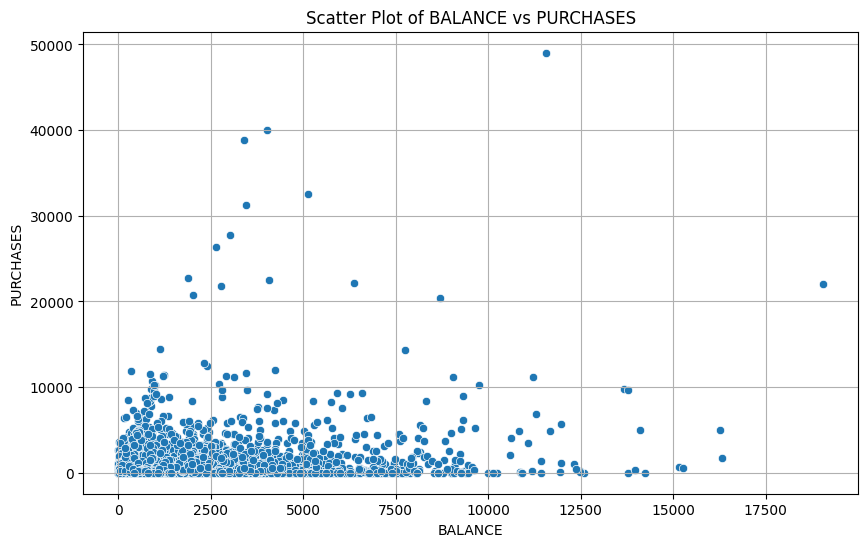

In [284]:
# Membuat scatter plot untuk 'BALANCE' vs. 'PURCHASES'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['BALANCE'], y=data['PURCHASES'])
plt.title('Scatter Plot of BALANCE vs PURCHASES')
plt.xlabel('BALANCE')
plt.ylabel('PURCHASES')
plt.grid(True)
plt.show()

**Insight:**

1. Sebagian besar ``data berkumpul di kuadran bawah kiri grafik,`` yang menunjukkan bahwa banyak nasabah memiliki saldo dan jumlah pembelian yang relatif rendah. Ini mungkin menandakan adanya segmen nasabah yang lebih konservatif dalam pengeluaran atau mungkin merupakan karakteristik dari produk atau layanan yang ditawarkan

2. ``Terdapat beberapa titik data yang cukup jauh dari kelompok data utama atau biasanya disebut dengan outlier.`` Titik-titik ini mewakili nasabah dengan kombinasi saldo dan pembelian yang tidak umum. Misalnya, ada beberapa nasabah dengan saldo yang sangat tinggi namun jumlah pembeliannya relatif rendah, atau sebaliknya

**Implikasi:**
 Data ini bisa digunakan untuk ``mengidentifikasi segmen-segmen nasabah yang berbeda berdasarkan pola pengeluaran mereka.`` Misalnya, nasabah dengan saldo tinggi dan pembelian tinggi bisa menjadi target untuk produk kredit atau investasi

#### **5.3. Credit Limit vs Payments**

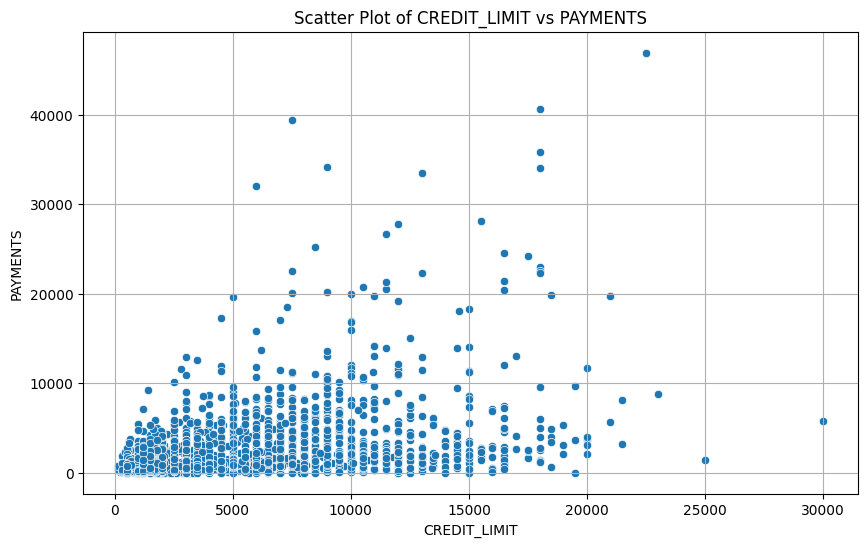

In [285]:
# Membuat scatter plot untuk CREDIT_LIMIT vs. PAYMENTS
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['CREDIT_LIMIT'], y=data['PAYMENTS'])
plt.title('Scatter Plot of CREDIT_LIMIT vs PAYMENTS')
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('PAYMENTS')
plt.grid(True)
plt.show()

**Insight:**

1. Sama seperti sebelumnya, ``sebagian besar data terkonsentrasi di bagian bawah kiri grafik,`` menunjukkan bahwa banyak orang memiliki limit kredit dan pembayaran yang relatif rendah

2. Terdapat juga beberapa titik data yang cukup jauh dari kelompok data utama ``(outlier)``

**Implikasi:**
Data ini bisa digunakan untuk ``mengidentifikasi segmen-segmen pelanggan yang berbeda berdasarkan pola pembayaran mereka.`` Misalnya, pelanggan dengan limit kredit tinggi dan pembayaran tinggi bisa menjadi target untuk produk kredit atau investasi



#### **5.4. One off Purchases vs Installments Purchases**

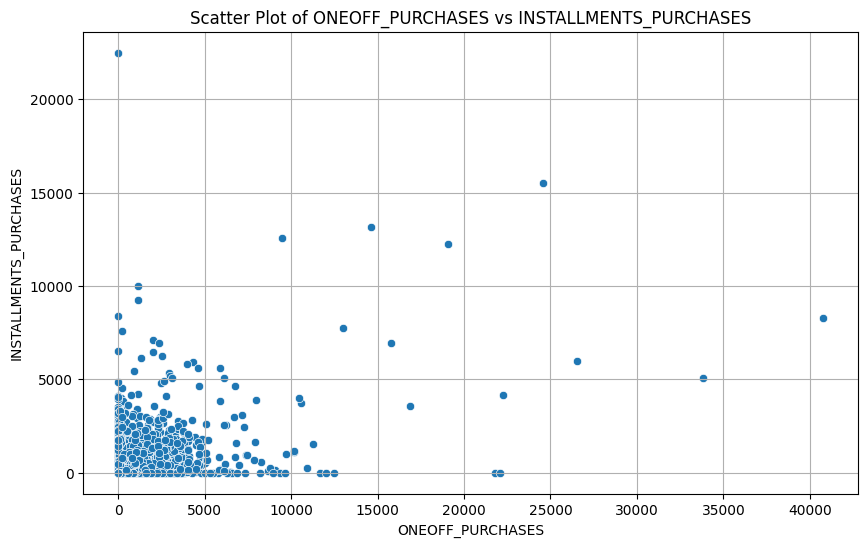

In [286]:
# Membuat scatter plot untuk ONEOFF_PURCHASES vs. INSTALLMENTS_PURCHASES
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['ONEOFF_PURCHASES'], y=data['INSTALLMENTS_PURCHASES'])
plt.title('Scatter Plot of ONEOFF_PURCHASES vs INSTALLMENTS_PURCHASES')
plt.xlabel('ONEOFF_PURCHASES')
plt.ylabel('INSTALLMENTS_PURCHASES')
plt.grid(True)
plt.show()

**Insight:**

1. ``Terdapat korelasi positif yang lemah`` dan sebagian besar ``data terkonsentrasi di bagian bawah kiri grafik,`` menunjukkan bahwa banyak konsumen memiliki jumlah pembelian satu kali dan angsuran yang relatif rendah

2. Terdapat pula ``outlier``

**Implikasi:** 
Data ini bisa digunakan untuk ``mengidentifikasi segmen-segmen pelanggan yang berbeda berdasarkan pola pembelian mereka.`` Misalnya, pelanggan dengan pembelian satu kali dan angsuran yang tinggi bisa menjadi target untuk produk kredit atau layanan keuangan lainnya

### **6. Feature Engineering**

In [225]:
# Menyalin dataframe 
df = data.copy()

#### **6.1. Cardinality Check**

In [226]:
# Set pengaturan tampilan pandas
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

# Membuat DataFrame untuk menghitung jumlah unique dan nilai unique
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

unique_val_df = pd.DataFrame(columns=['Nama Kolom', 'Jumlah Unique', 'Unique'],
                     data=listItem)

unique_val_df

Nama Kolom  Jumlah Unique  \
0                            CUST_ID           4475   
1                            BALANCE           4439   
2                  BALANCE_FREQUENCY             42   
3                          PURCHASES           3218   
4                   ONEOFF_PURCHASES           2073   
5             INSTALLMENTS_PURCHASES           2357   
6                       CASH_ADVANCE           2155   
7                PURCHASES_FREQUENCY             47   
8         ONEOFF_PURCHASES_FREQUENCY             44   
9   PURCHASES_INSTALLMENTS_FREQUENCY             47   
10            CASH_ADVANCE_FREQUENCY             46   
11                  CASH_ADVANCE_TRX             55   
12                     PURCHASES_TRX            147   
13                      CREDIT_LIMIT            153   
14                          PAYMENTS           4350   
15                  MINIMUM_PAYMENTS           4317   
16                  PRC_FULL_PAYMENT             47   
17                            TENURE              7   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Unique  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [788, 1902, 2322, 3426, 3976, 4266, 4360, 4680, 5884, 24, 172, 190, 206, 374, 394, 422, 540, 570, 652, 936, 966, 1060, 1090, 1250, 1432, 1434, 1454, 1830, 1882, 1908, 2012, 2062, 2068, 2116, 2176, 2256, 2326, 2418, 2422, 2448, 2480, 2512, 2556, 2682, 2684, 2802, 2814, 2846, 2946, 3086, 3096, 3294, 3420, 3612, 3756, 3814, 4014, 4020, 4160, 4182, 4192, 4350, 4414, 4498, 4750, 4772, 4896, 4922, 4972, 5002, 5010, 5084, 5114, 5246, 5452, 5588, 5650, 5668, 5746, 5758, 5828, 5934, 6026, 6062, 6182, 6258, 6272, 6294, 6344, 6394, 6416, 6474, 6718, 6720, 6812, 6908, 6996, 7050, 7188, 7226, ...]  
1                                                                                                [16.581535, 943.584041, 1.979916, 461.45572, 1053.59473, 2237.238086, 2730.843802, 424.994385, 18.885677, 0.004816, 867.728471, 41.25567, 857.767403, 5850.1729, 545.819208, 64.080909, 10.286805, 576.890374, 1391.33075, 1.155609, 76.096025, 1779.796624, 1610.040203, 1557.750089, 330.273411, 1151.703776, 3144.690403, 0.0, 154.641707, 13.362018, 7.634737, 82.470475, 0.401279, 73.

| Kolom | Tipe Kardinalitas | 
| --- | --- |
| CUST_ID | Ordinal | 
| BALANCE | Numerikal | 
| BALANCE_FREQUENCY | Numerikal | 
| PURCHASES | Numerikal | 
| ONEOFF_PURCHASES | Numerikal | 
| INSTALLMENTS_PURCHASES | Numerikal | 
| CASH_ADVANCE | Numerikal | 
| PURCHASES_FREQUENCY | Numerikal | 
| ONEOFF_PURCHASES_FREQUENCY | Numerikal |
| PURCHASES_INSTALLMENTS_FREQUENCY | Numerikal |  
| CASH_ADVANCE_FREQUENCY | Numerikal | 
| CASH_ADVANCE_TRX | Numerikal | 
| PURCHASES_TRX | Numerikal | 
| CREDIT_LIMIT | Numerikal |
| PAYMENTS| Numerikal |
| MINIMUM_PAYMENTS | Numerikal | 
| PRC_FULL_PAYMENT | Numerikal |
| TENURE | Ordinal | 

In [227]:
# drop kolom TENURE, CUST_ID
df = df.drop(['CUST_ID', 'TENURE'], axis=1)

**Asumsi:**

* Setiap ``CUST_ID`` memang benar-benar unik, maka kolom ini lebih berfungsi sebagai ``identitas individu dan tidak membawa informasi tambahan yang dapat digunakan dalam analisis numerik.`` Menghapus kolom ini tidak akan menghilangkan informasi penting

* ``TENURE memiliki variasi nilai yang sangat sedikit,`` maka kolom ini mungkin tidak memberikan kontribusi yang signifikan dalam menjelaskan variabilitas data

#### **6.2. Handling Missing Value**

In [228]:
# Menghapus baris yang memiliki nilai missing
df.dropna(inplace=True)

In [229]:
# Melihat jumlah missing value
print("Jumlah Missing Value: ", df.isnull().sum())

Jumlah Missing Value:  BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
dtype: int64


* ``Jumlah data yang hilang relatif kecil.`` Maka, jika hanya sebagian kecil data yang hilang, menghapus data tersebut mungkin tidak berdampak signifikan pada hasil analisis

* Diasumsikan juga bahwa data yang hilang ``tidak memberikan informasi tambahan yang relevan dengan tujuan analisis`` atau data yang hilang tidak mengandung informasi penting

#### **6.3. Handling Outlier**

In [230]:
# Skala data menggunakan RobustScaler
scaler_robust = RobustScaler()
data_scaled = pd.DataFrame(scaler_robust.fit_transform(df), columns=df.columns)

``RobustScaler`` digunakan untuk ``menormalkan data sebelum mengidentifikasi`` dan ``menghapus outlier menggunakan LOF``

``RobustScaler`` juga lebih ``tahan terhadap pengaruh outlier`` dibandingkan dengan scaler lainnya seperti StandardScaler. Ini karena ``RobustScaler`` menggunakan kuartil (nilai tengah dan kuartil pertama dan ketiga) untuk menghitung skala, sehingga outlier tidak terlalu memengaruhi hasil penskalaan

In [231]:
# Mengidentifikasi dan menghapus outlier menggunakan LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['lof_label'] = lof.fit_predict(data_scaled)

``LocalOutlierFactor`` diatur dengan ``n_neighbors=20`` dan ``contamination=0.05`` untuk ``mendeteksi outlier``

In [232]:
# Melihat jumlah outlier
print(df['lof_label'].value_counts())

lof_label
 1    4100
-1     216
Name: count, dtype: int64


* Sebanyak ``4100`` data dianggap sebagai data normal (nilai 1 pada lof_label) 

* Terdapat ``216`` data yang dikategorikan sebagai outlier (nilai -1 pada lof_label)

Jadi, berdasarkan output tersebut, dapat disimpulkan bahwa dataset yang memiliki ``proporsi outlier yang relatif kecil`` (sekitar 5%) dibandingkan dengan data normal. Ini menunjukan bahwa sebagian besar data berada dalam rentang yang diharapkan dan tidak memiliki karakteristik ekstrem yang signifikan

In [233]:
# Menghapus baris yang dianggap outlier
df1 = df[df['lof_label'] != -1]
df1.drop('lof_label', axis=1, inplace=True)


In [234]:
# Menampilkan informasi dari dataframe yang telah dibersihkan
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4100 entries, 1 to 4474
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           4100 non-null   float64
 1   BALANCE_FREQUENCY                 4100 non-null   float64
 2   PURCHASES                         4100 non-null   float64
 3   ONEOFF_PURCHASES                  4100 non-null   float64
 4   INSTALLMENTS_PURCHASES            4100 non-null   float64
 5   CASH_ADVANCE                      4100 non-null   float64
 6   PURCHASES_FREQUENCY               4100 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        4100 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  4100 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            4100 non-null   float64
 10  CASH_ADVANCE_TRX                  4100 non-null   int64  
 11  PURCHASES_TRX                     4100 non-null   int64  
 12  CREDIT_LIMI

In [283]:

# Menampilkan beberapa baris dari data yang telah dibersihkan
df1.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1   943.584041              0.875      103.0             103.0   
3   461.455720              1.000      585.0             585.0   
4  1053.594730              1.000     1450.0            1450.0   
5  2237.238086              1.000      120.0             120.0   
7   424.994385              0.375     1200.0            1200.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1                       0.125                               0.0   
3                       0.125                               0.0   
4                       0.125                               0.0   
5                       0.125                               0.0   
7                       0.125                               0.0   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1                     0.0                 0              1        1000.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
7                     0.0                 0              1        1200.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  cluster  
1  215.325023        410.484825               0.0        1  
3  258.032630        151.696433               0.0        1  
4  397.090516        227.143184               0.0        1  
5  343.102984        712.986387               0.0        1  
7   57.266292         56.720210               0.0        1

#### **6.4. Feature Scaling**

In [236]:
# Skala ulang data yang telah dibersihkan menggunakan MinMaxScaler
scaler_minmax = MinMaxScaler()
df1_scaled = scaler_minmax.fit_transform(df1)


``MinMaxScaler`` digunakan untuk ``menormalkan data yang telah dibersihkan dari outlier``

Digunakan juga ketika rentang nilai fitur sangat berbeda dan kita ingin semua fitur ``memiliki skala yang sama``

In [237]:
# Dimensionality Reduction menggunakan PCA
pca = PCA()
pca.fit(df1_scaled)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

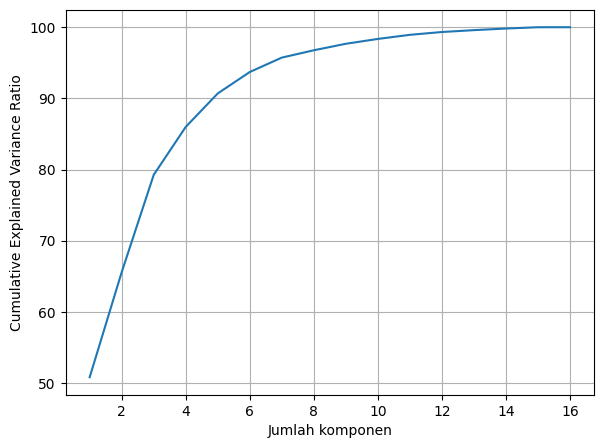

In [238]:
# Plot Cumulative menjelaskan variance ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(df1.columns) + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Jumlah komponen')
plt.ylabel('Cumulative Explained Variance Ratio')

* Plot kumulatif variansi ratio ini adalah visualisasi yang digunakan dalam analisis komponen utama (PCA) untuk ``menentukan jumlah komponen utama yang optimal`` untuk mempertahankan sebagian besar variansi dalam data

* Semakin ke kanan kita bergerak pada sumbu X (semakin banyak komponen utama yang digunakan), semakin besar persentase total variansi yang dijelaskan. Ini logis, karena setiap komponen tambahan akan selalu menjelaskan sedikit lebih banyak variansi

* Disini saya blum menentukan komponen utamanya tetapi berada di bagian elbow method dengan judul ``Find the Optimal Number of Clusters``

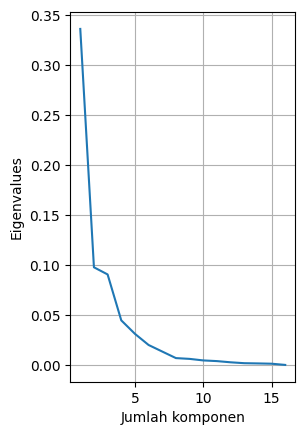

In [239]:
# Plot Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, len(df1.columns) + 1), pca.explained_variance_)
plt.xlabel('Jumlah komponen')
plt.ylabel('Eigenvalues')
plt.show()

Begitu pula dengan ini, ``Plot eigenvalues`` adalah ``visualisasi yang digunakan dalam analisis komponen utama (PCA) untuk membantu menentukan jumlah komponen utama yang optimal.`` Setiap titik pada plot mewakili nilai eigen dari sebuah komponen utama

In [240]:
# Menentukan jumlah fitur untuk mempertahankan 95% informasi
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
print(f'Jumlah fitur yang dipertahankan untuk 95% informasi: {num_features}')


Jumlah fitur yang dipertahankan untuk 95% informasi: 7


 Diperoleh informasi bahwa ``7 fitur`` dapat dipertahankan untuk menangkap ``95%`` varians informasi. Ini berarti bahwa dengan menggunakan ``7 fitur`` ini, kita masih dapat menjelaskan ``95%`` dari variansi yang ada pada data asli. Hal ini dapat berguna untuk melakukan reduksi dimensionalitas data, sehingga dapat menghemat waktu dan sumber daya komputasi yang dibutuhkan untuk proses analisa selanjutnya dan ini akan membantu untuk mempercepat proses analisa selanjutnya dan menghemat sumber daya komputasi yang dibutuhkan

In [241]:
# Melatih model dengan 95% informasi dataset asli
pca = PCA(n_components=0.95)
pca.fit(df1_scaled)

df1_pca = pca.transform(df1_scaled)


``PCA`` diterapkan untuk mengurangi dimensi data dan mempertahankan ``95%`` dari informasi dataset asli

In [242]:
# Menampilkan beberapa baris dari data yang telah di-transformasi dengan PCA
print(pd.DataFrame(df1_pca).head())

          0         1         2         3         4         5         6
0 -0.535013  0.008304  0.030309 -0.177560  0.165037 -0.034250  0.023843
1 -0.517184  0.050354 -0.006786 -0.114101  0.265205 -0.056879  0.063893
2 -0.508193  0.079972 -0.004909 -0.099162  0.236675 -0.104251  0.093734
3 -0.524397  0.069841 -0.032735 -0.069519  0.215379 -0.107719 -0.018729
4 -0.566682 -0.117063  0.240852 -0.474632 -0.227371  0.011198  0.076029


* Dengan menggunakan ``PCA,`` ini sudah berhasil mengurangi dimensi data asli menjadi 7 komponen utama. Ini berarti kita dapat merepresentasikan data asli dengan hanya menggunakan ``7 fitur baru,`` alih-alih fitur asli yang mungkin jauh lebih banyak

* Komponen utama pertama ``(kolom 0)`` umumnya menjelaskan proporsi ``varians terbesar.`` Ini menunjukkan bahwa komponen utama pertama menangkap sebagian besar informasi yang terkandung dalam data asli. Komponen utama selanjutnya menangkap varians yang ``semakin kecil``

#### **6.5. Find the Optimal Number of Clusters**


##### **6.5.1. Elbow Method**

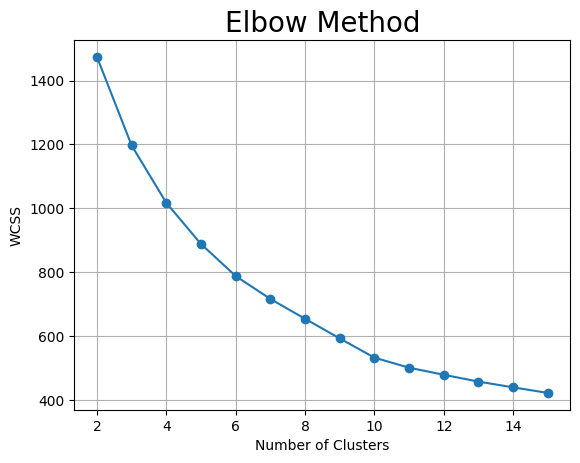

In [243]:
# Temukan jumlah cluster yang optimal menggunakan Elbow Method
wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(df1_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Saya memilih cluster yang optimal ``3``, dengan asumsi:

* ``Penurunan WCSS melambat signifikan`` yang sudah diamati bahwa penurunan nilai WCSS mulai melambat secara signifikan setelah jumlah cluster mencapai ``3.`` Artinya, penambahan cluster setelah itu tidak memberikan peningkatan yang signifikan dalam kualitas pemodelan

* ``Trade-off antara kompleksitas dan akurasi dengan memilih 3 cluster,`` yang mana berusaha mencapai keseimbangan antara kompleksitas model dan akurasi hasil clustering. Model dengan terlalu banyak cluster dapat menjadi terlalu kompleks dan rentan terhadap overfitting, sedangkan model dengan terlalu sedikit cluster mungkin tidak mampu menangkap pola yang sebenarnya ada dalam data

##### **6.5.2. Silhoutte Plot & Silhoutte Score**

In [244]:
# Function untuk membuat Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Membuat subplot dengan 1 baris dan 2 kolom
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # Subplot pertama adalah silhouette plot
        # Koefisien siluet dapat berkisar dari -1, 1, tetapi dalam contoh ini, semuanya berada di dalam [-0,1, 1]
        ax1.set_xlim([-0.1, 1])
        # (n_kelompok + 1)*10 adalah untuk menyisipkan ruang kosong di antara plot siluet masing-masing kelompok, untuk membatasi mereka dengan jelas
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Memberi label plot siluet dengan nomor klasternya di bagian tengah
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # Garis vertikal untuk skor siluet rata-rata dari semua nilai
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot ke-2 yang menunjukkan cluster aktual yang terbentuk
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Memberi label pada cluster
        centers = clusterer.cluster_centers_

        # Gambarlah lingkaran putih di pusat cluster
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.40364426154583216
For n_clusters = 3 The average silhouette_score is : 0.3915260449231206
For n_clusters = 4 The average silhouette_score is : 0.35518008033833104
For n_clusters = 5 The average silhouette_score is : 0.34317472453624753
For n_clusters = 6 The average silhouette_score is : 0.3523841664435902
For n_clusters = 7 The average silhouette_score is : 0.3207780805491168
For n_clusters = 8 The average silhouette_score is : 0.3261490592746566
For n_clusters = 9 The average silhouette_score is : 0.3504993141750896
For n_clusters = 10 The average silhouette_score is : 0.3276080409419799
For n_clusters = 11 The average silhouette_score is : 0.3228044644665713
For n_clusters = 12 The average silhouette_score is : 0.3224943552260998
For n_clusters = 13 The average silhouette_score is : 0.3233266956714148
For n_clusters = 14 The average silhouette_score is : 0.3280146983334349


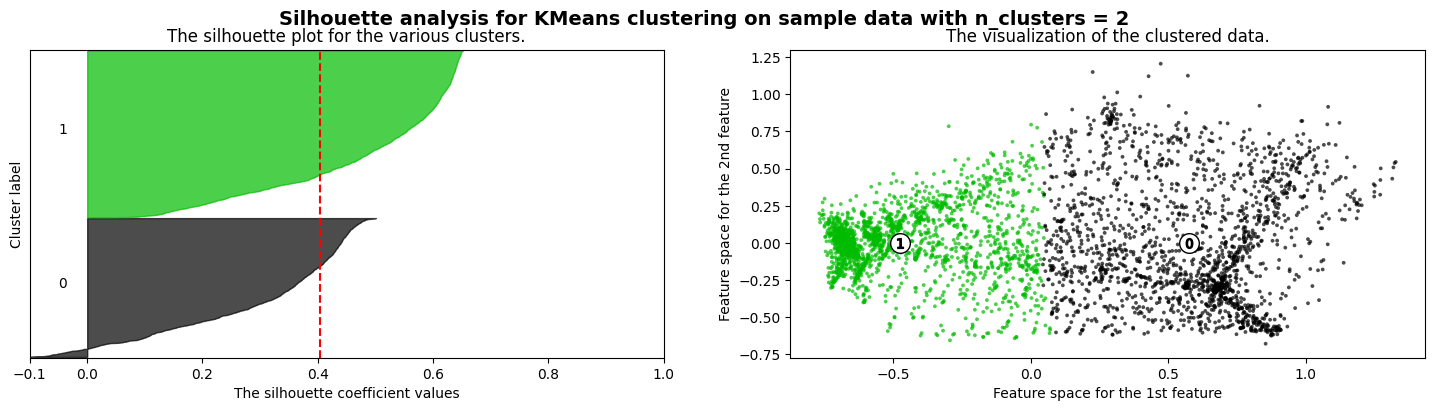

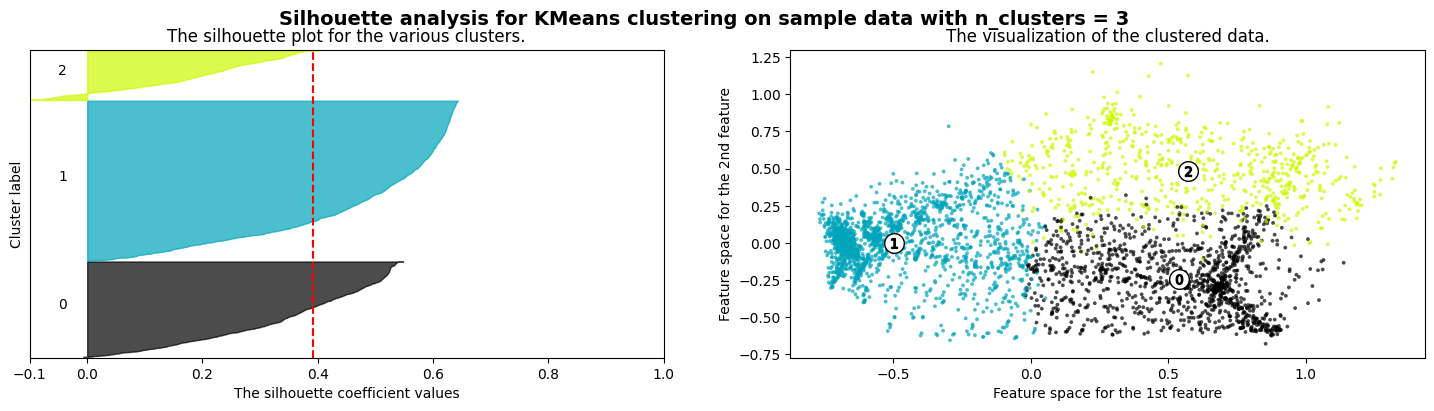

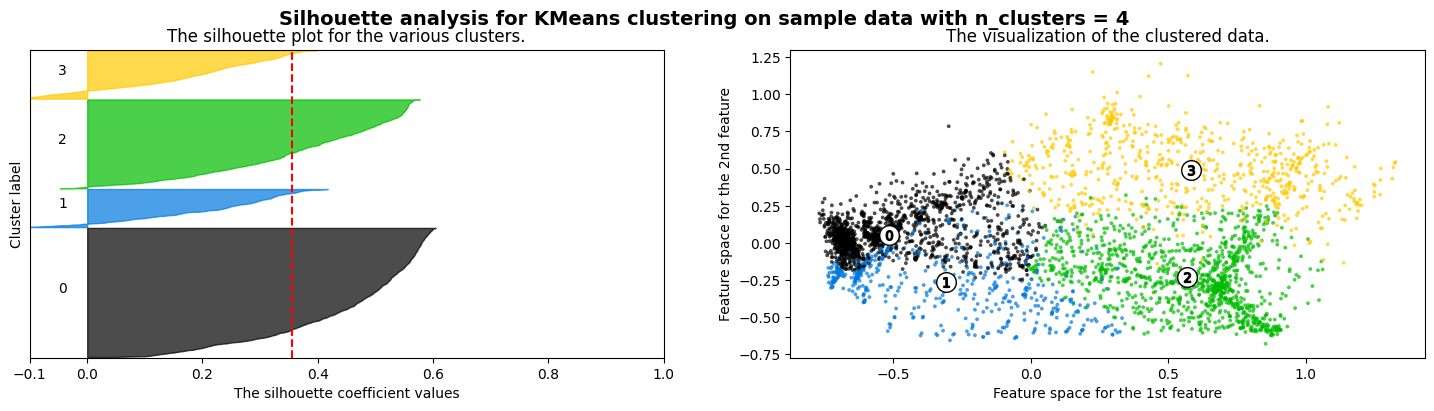

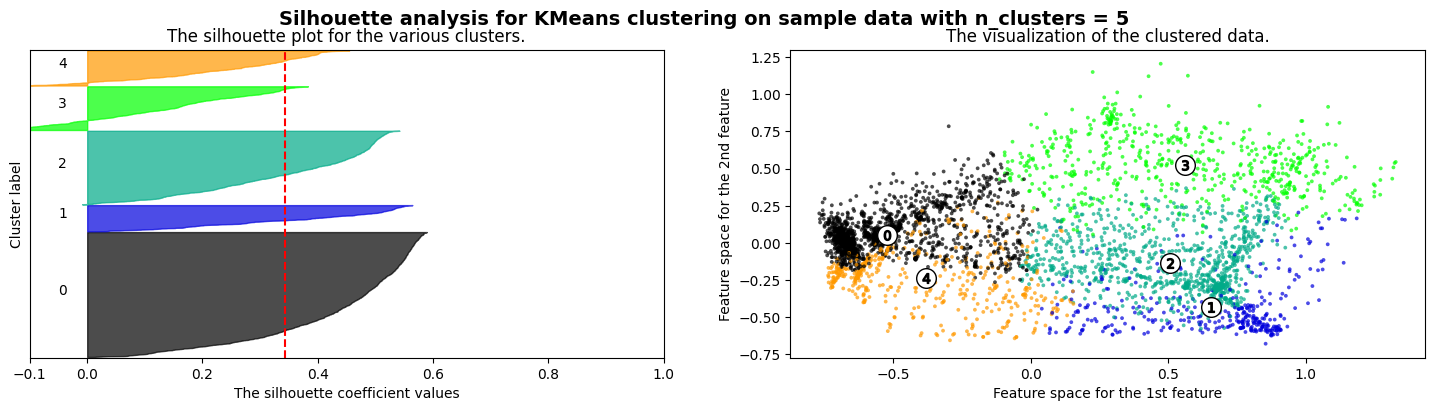

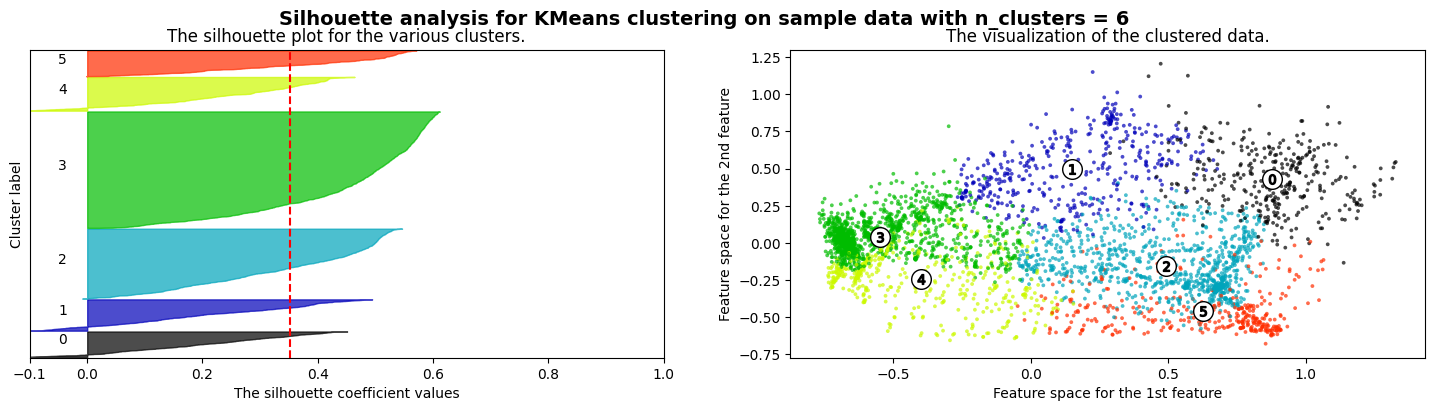

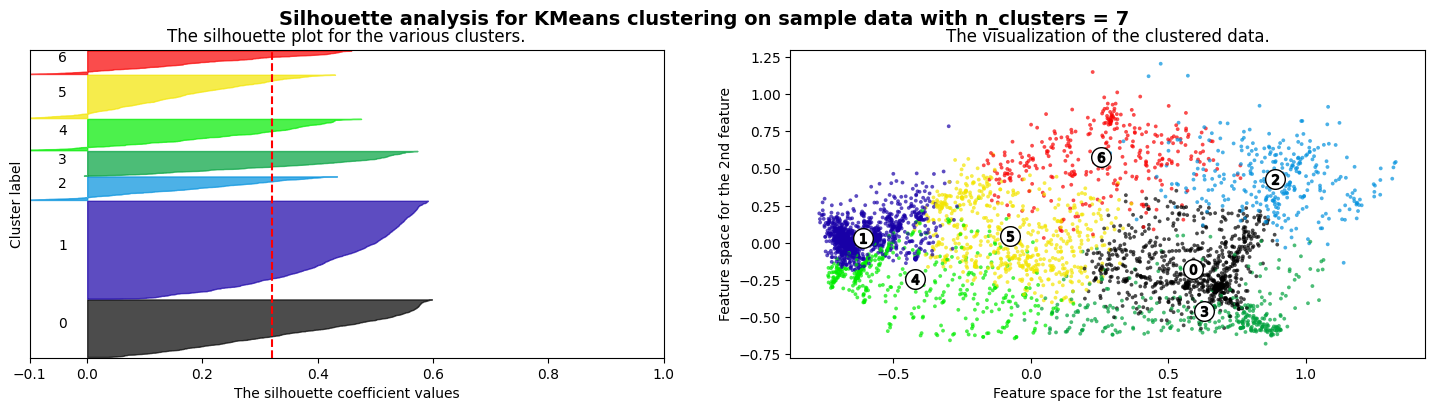

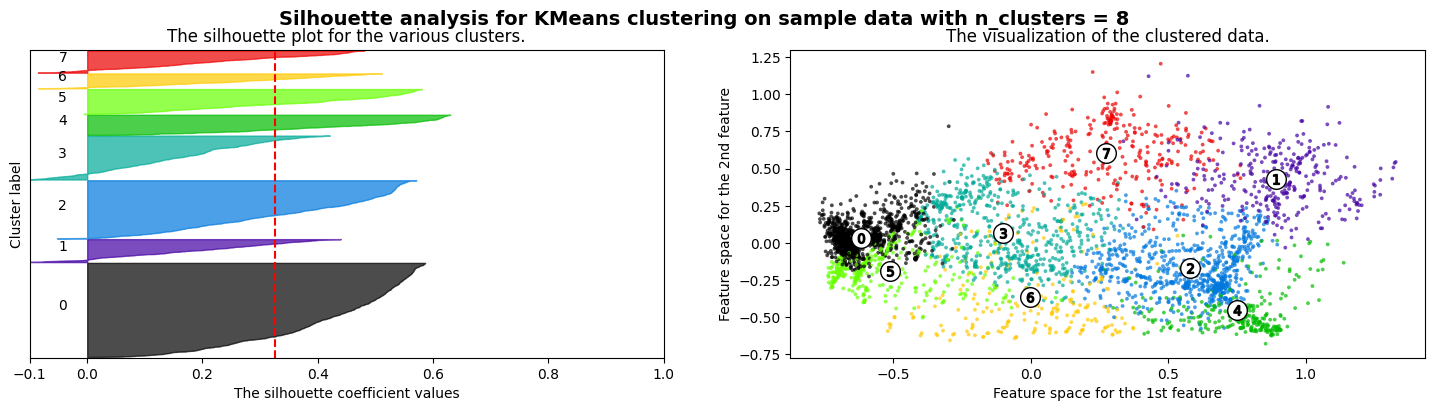

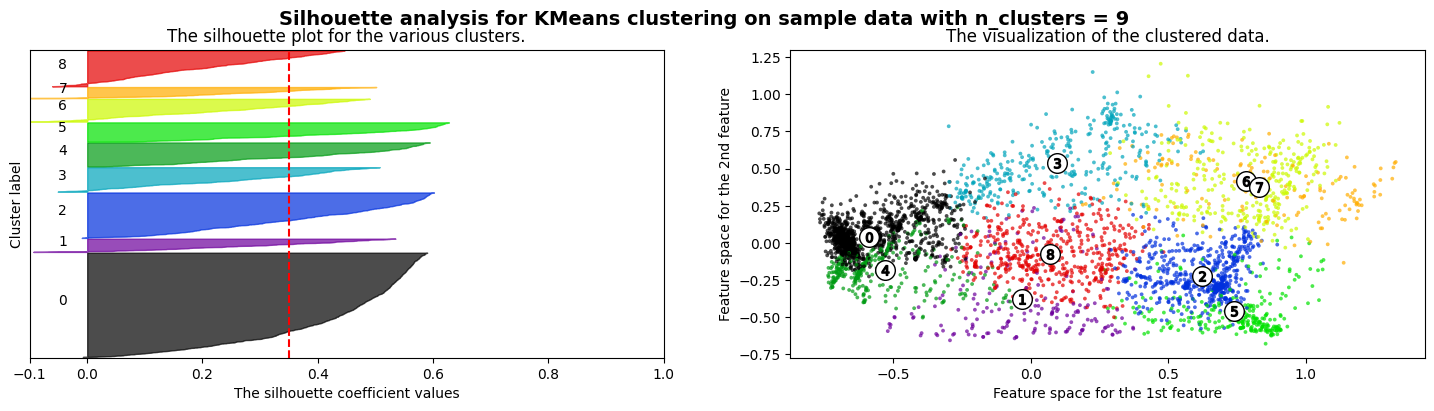

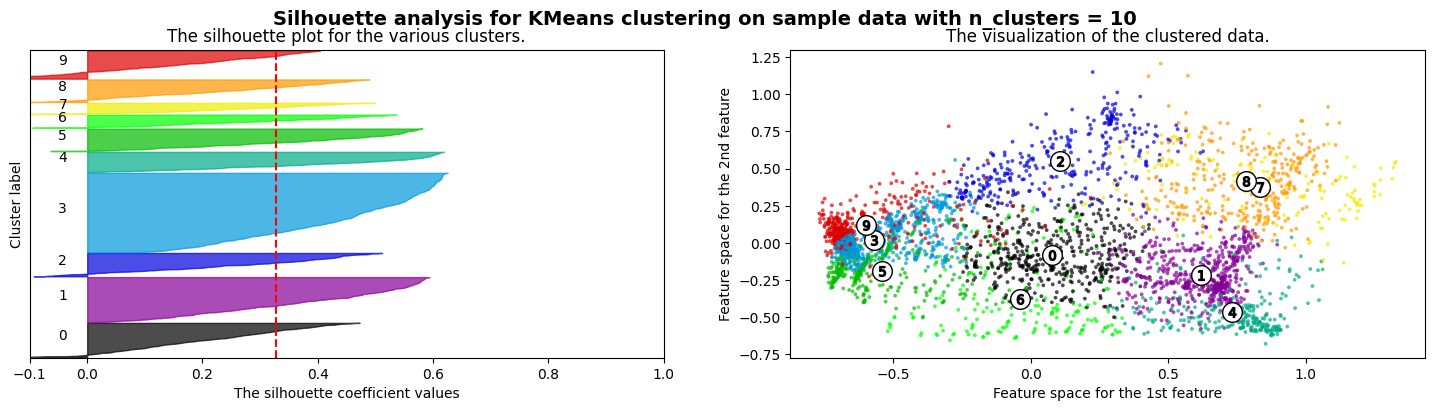

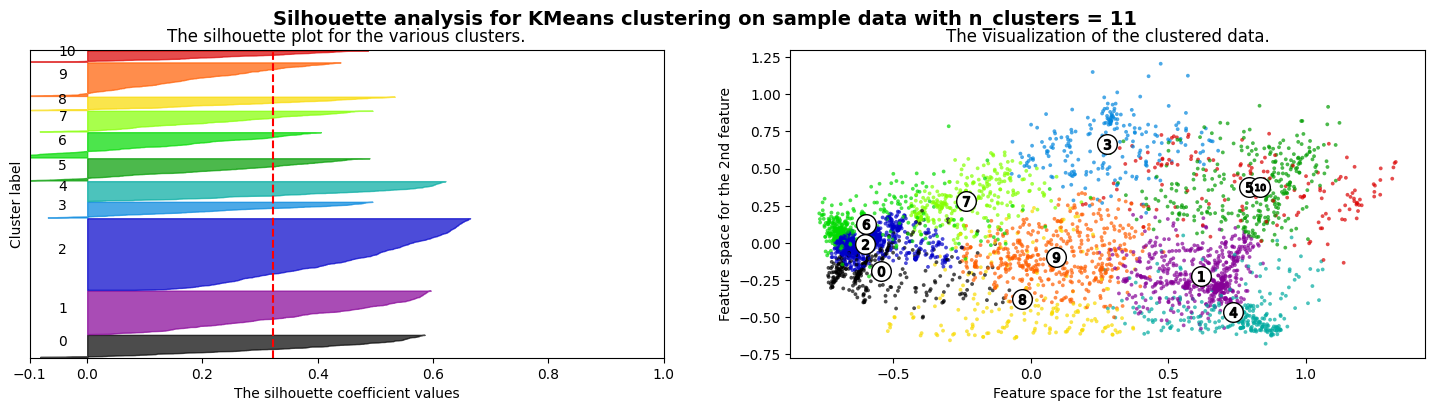

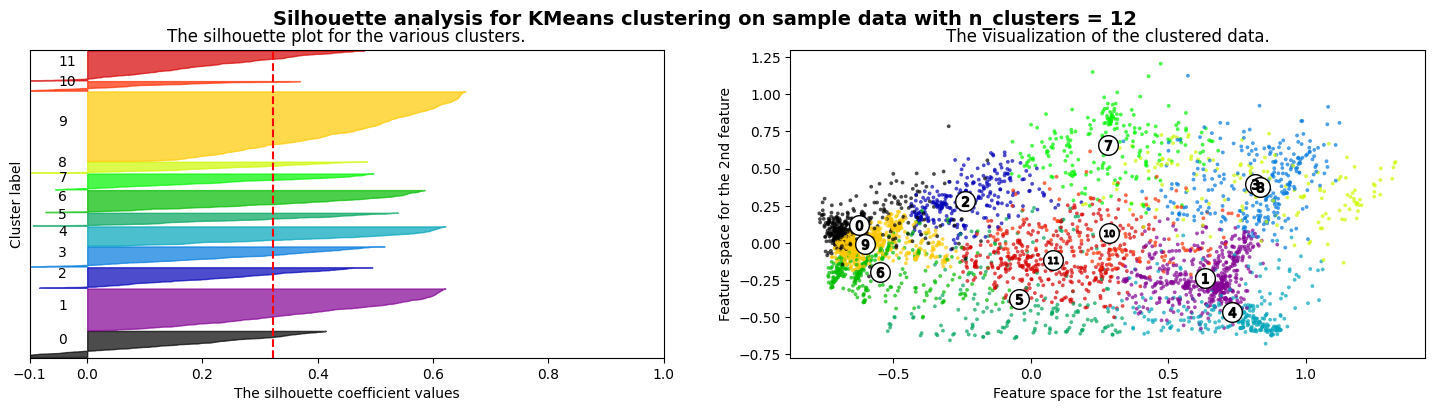

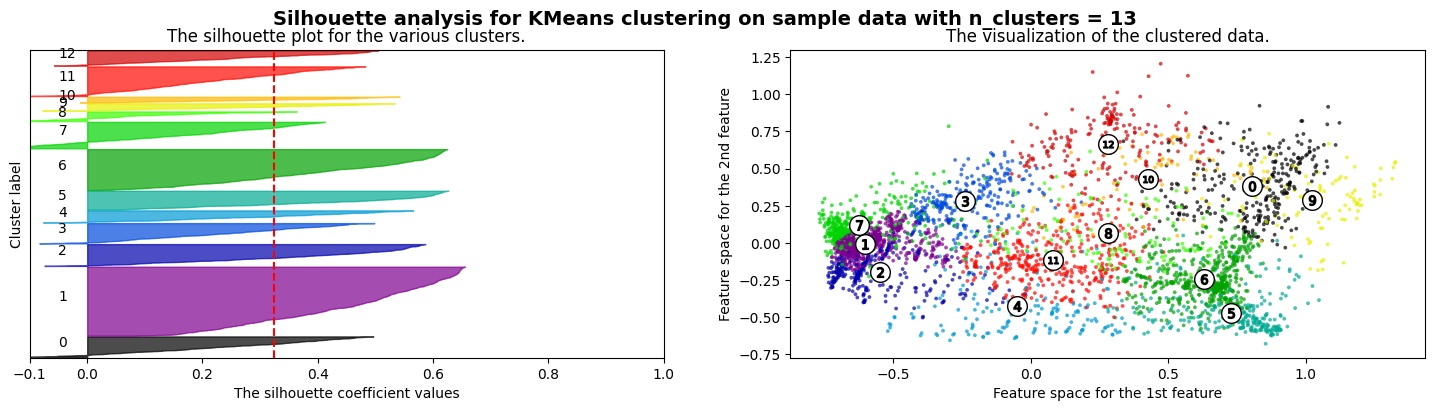

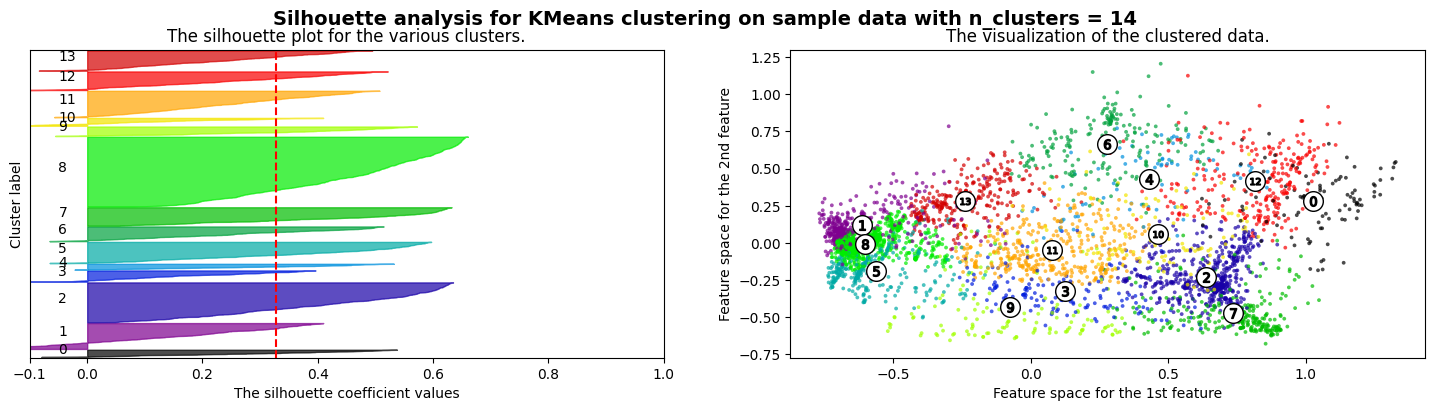

In [245]:
# Menampilkan Skor Siluet dan Plot Siluet Plot

plot_silhouette(range(2, max_cluster), df1_pca, random_state)

* Plot silhouette pada gambar memberikan gambaran visual tentang kualitas pengelompokan (clustering) yang dilakukan oleh algoritma K-Means dengan jumlah cluster sebanyak ``3``

* Yang mana ``Cukup Baik`` dari Nilai rata-rata ``silhouette`` berada di atas ``0,`` menunjukkan bahwa sebagian besar data point ditempatkan dengan benar dalam clusternya

### **7. Training with the Optimal Number of Clusters**

In [246]:
# Melatih model KMeans dengan jumlah klaster optimal
random_state = 42
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=random_state)
pred = km.fit_predict(df1_pca)
pred

array([1, 1, 1, ..., 2, 1, 0])

In [247]:
# Memasukkan hasil klastering ke dalam dataset asli
df1['cluster'] = pred
df1.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
1   943.584041              0.875      103.0             103.0   
3   461.455720              1.000      585.0             585.0   
4  1053.594730              1.000     1450.0            1450.0   
5  2237.238086              1.000      120.0             120.0   
7   424.994385              0.375     1200.0            1200.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
1                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
1                       0.125                               0.0   
3                       0.125                               0.0   
4                       0.125                               0.0   
5                       0.125                               0.0   
7                       0.125                               0.0   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
1                     0.0                 0              1        1000.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
7                     0.0                 0              1        1200.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  cluster  
1  215.325023        410.484825               0.0        1  
3  258.032630        151.696433               0.0        1  
4  397.090516        227.143184               0.0        1  
5  343.102984        712.986387               0.0        1  
7   57.266292         56.720210               0.0        1

Hasil klastering ditambahkan ke dataset asli sebagai kolom ``'cluster'``

* Data pelanggan kartu kredit terbagi menjadi ``tiga segmen utama`` berdasarkan pola penggunaan kartu kredit mereka

* Setiap segmen kemungkinan memiliki ``karakteristik yang berbeda,`` seperti tingkat pengeluaran, frekuensi transaksi, dan preferensi pembayaran

### **8. Exploratory Data Analysis II (EDA II)**

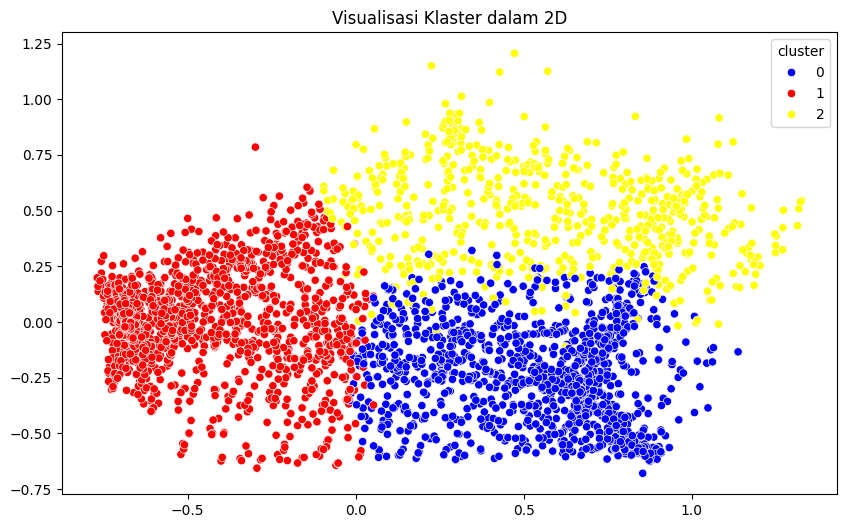

In [248]:
# Visualisasi klaster dalam 2D
pca_2d = PCA(n_components=2)
data_clean_pca_2d = pca_2d.fit_transform(df1_scaled)

# Definisi warna khusus
custom_palette = ['blue', 'red', 'yellow']

# Menampilkan visualisasi
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_clean_pca_2d[:,0], y=data_clean_pca_2d[:,1], hue=df1['cluster'], palette=custom_palette)
plt.title('Visualisasi Klaster dalam 2D')
plt.show()

* Terdapat tiga klaster yang dapat dibedakan dengan warna: ``merah (klaster 1), biru (klaster 0), dan kuning (klaster 2)``

* Klaster merah dan biru tampaknya ``memiliki pemisahan yang jelas,`` sedangkan klaster kuning menunjukkan ``tumpang tindih dengan klaster biru`` karena kita hanya melihat 2D saja, jadi kita hanya bisa melihat dari depan saja 

* Klaster merah (1) memiliki ``distribusi yang lebih rapat`` dan berada di sebelah kiri grafik

* Klaster biru (0) terletak di bagian bawah grafik dengan ``distribusi yang agak tersebar``

* Klaster kuning (2) cenderung ``terdistribusi di bagian atas grafik dan lebih tersebar`` dibandingkan dengan klaster lainnya

In [249]:
# Menghitung jumlah kemunculan setiap nilai unik dalam kolom cluster
df1['cluster'].value_counts()

cluster
1    2151
0    1284
2     665
Name: count, dtype: int64

* Klaster ``1`` memiliki ``jumlah data poin paling banyak yaitu 2.151,`` hampir dua kali lipat dari klaster ``0`` dan lebih dari tiga kali lipat dari klaster ``2.``
Ini menunjukkan bahwa ada banyak data yang memiliki karakteristik yang mirip dan dikelompokkan ke dalam klaster ``1``

* Klaster ``0`` memiliki ``jumlah data poin yang lebih sedikit dibandingkan dengan klaster 1,`` tetapi lebih banyak dibandingkan dengan klaster ``2.``
Ukuran menengah ini bisa menunjukkan bahwa klaster ``0`` berisi data dengan karakteristik yang tidak terlalu umum namun juga tidak terlalu jarang

* Klaster ``2`` memiliki jumlah data poin paling sedikit, ``hanya 665.``
Ini menunjukkan bahwa data yang masuk ke dalam klaster ``2`` memiliki karakteristik yang lebih jarang ditemukan dibandingkan dengan dua klaster lainnya

In [288]:
# Menghitung nilai rata-rata untuk setiap klaster
cluster_means = df1.groupby('cluster').mean()

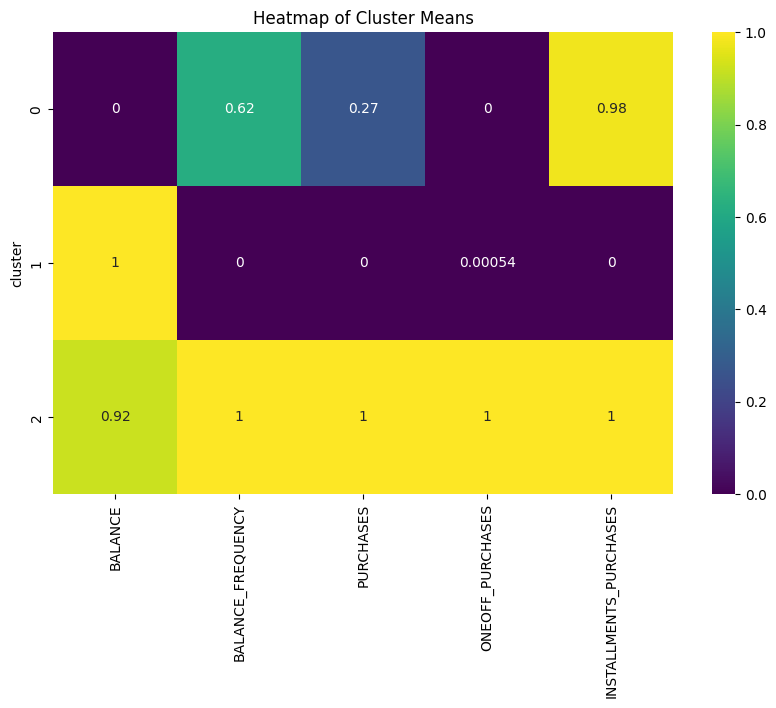

In [251]:
# Skala nilai rata-rata
scaler = MinMaxScaler()
scaled_means = pd.DataFrame(scaler.fit_transform(cluster_means), index=cluster_means.index, columns=cluster_means.columns)

# Heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(scaled_means.iloc[:, :5], annot=True, cmap='viridis')
plt.title('Heatmap of Cluster Means')
plt.show()


##### **Karakteristik Setiap Cluster:**

**1. Cluster 0**
   * Memiliki nilai tinggi pada ``BALANCE`` dan ``INSTALLMENTS_PURCHASES``
   * Memiliki nilai rendah pada ``BALANCE_FREQUENCY, PURCHASES,`` dan ``ONEOFF_PURCHASES``
   * Ini menandakan bahwa pelanggan dalam cluster ini cenderung memiliki ``saldo tinggi,`` sering melakukan pembelian secara cicilan, tetapi ``jarang melakukan pembelian secara keseluruhan``

**2. Cluster 1**
   * Memiliki nilai tinggi pada ``BALANCE dan CASH_ADVANCE``
   * Nilai lainnya ``sangat rendah`` 
   * Ini menunjukan bahwa pelanggan dalam cluster ini ``cenderung memiliki saldo tinggi dan sering melakukan penarikan tunai``

**3. Cluster 2**
   * ``Memiliki nilai tinggi pada semua fitur`` kecuali ``BALANCE_FREQUENCY``
   * Ini menunjukan bahwa pelanggan dalam cluster ini ``sangat aktif dalam bertransaksi,`` baik pembelian maupun penarikan tunai


##### **Perbedaan Antar Cluster**

**1. Cluster 0 vs Cluster 1:** Perbedaan utama adalah pada ``PURCHASES`` dan ``CASH_ADVANCE.`` Cluster 0 lebih cenderung melakukan pembelian, sementara Cluster 1 lebih cenderung melakukan penarikan tunai

**2. Cluster 0 vs Cluster 2:** Perbedaan utama adalah pada ``BALANCE_FREQUENCY.`` Cluster 2 memiliki frekuensi pembaruan saldo yang lebih tinggi

**3. Cluster 1 vs Cluster 2:** Perbedaan utama adalah pada ``semua fitur kecuali CASH_ADVANCE.`` Cluster 2 jauh lebih aktif dalam bertransaksi


In [252]:
# Sebuah list yang berisi nama-nama kolom dari DataFrame cluster_means
cluster_col = cluster_means.columns.tolist()

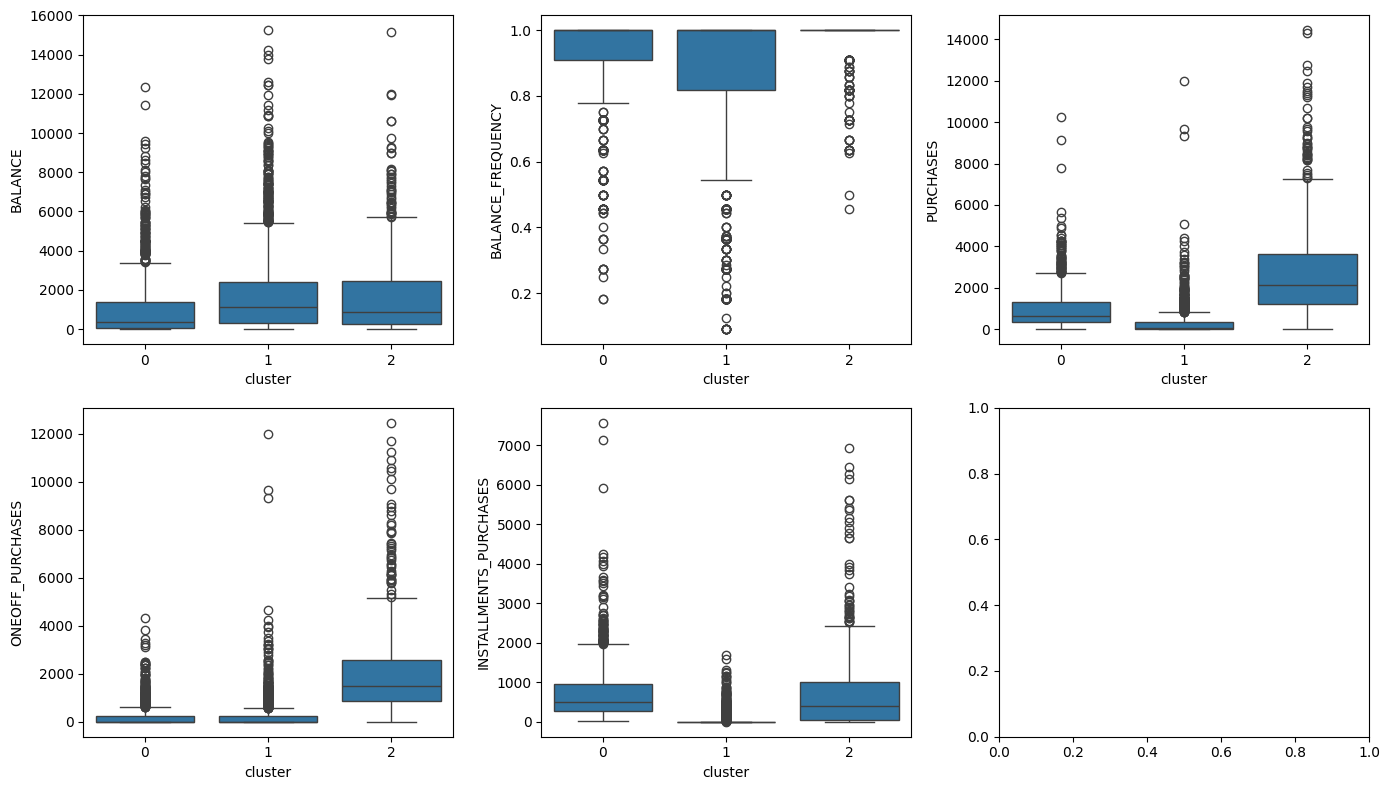

In [253]:
# Membandingkan distribusi beberapa fitur numerik di antara berbagai cluster
fig, axes = plt.subplots(2, 3, figsize=(14,8))

axes = axes.flatten()

for ax, col in zip(axes, cluster_col[:5]):
    _ = sns.boxplot(x=df1["cluster"], y=df1[col], ax=ax)
    plt.tight_layout()

**Insight:**

**1. BALANCE (Saldo)**
  * Distribusi saldo terlihat cukup mirip di antara semua klaster ``(0, 1, 2)``

**2. BALANCE_FREQUENCY (Frekuensi Saldo)**
  * Klaster ``0`` dan klaster ``1`` memiliki frekuensi saldo yang sangat tinggi ``(dekat dengan 1),`` sedangkan klaster ``2`` memiliki distribusi yang lebih bervariasi

**3. PURCHASES (Pembelian)**
  * Klaster ``2`` memiliki nilai median pembelian yang lebih tinggi dibandingkan dengan klaster ``0`` dan ``1``

**4. ONEOFF_PURCHASES (Pembelian Sekali)**
  * Mayoritas data di klaster ``0`` memiliki nilai pembelian sekali yang lebih rendah dibandingkan dengan klaster ``1`` dan ``2``

**5. INSTALLMENTS_PURCHASES (Pembelian Cicilan)**
  * Klaster ``2`` menunjukkan distribusi nilai cicilan yang lebih tinggi dibandingkan dengan klaster ``0`` dan ``1``


**Kesimpulan:**
1. Klaster ``2`` tampaknya memiliki anggota dengan aktivitas finansial yang lebih tinggi, baik dalam hal saldo, pembelian, maupun pembelian sekali dan cicilan

2. Klaster ``0`` dan ``1`` memiliki pola yang lebih mirip satu sama lain dalam beberapa fitur, terutama dalam frekuensi saldo



### **9. Model Saving**

In [254]:
# Menyimpan model, scaler, dan PCA

# Simpan Scaler
with open('scaler_robust.pkl', 'wb') as file_1:
    pickle.dump(scaler_robust, file_1)

with open('scaler_minmax.pkl', 'wb') as file_2:
    pickle.dump(scaler_minmax, file_2)

# Simpan PCA
with open('pca_model.pkl', 'wb') as file_3:
    pickle.dump(pca, file_3)

# Simpan model KMeans
with open('kmeans_model.pkl', 'wb') as file_4:
    pickle.dump(km, file_4)

print("Model dan scaler telah disimpan")

Model dan scaler telah disimpan


### **10. Model Load**

In [255]:
# Memuat model, scaler, dan PCA

# Memuat Scaler
with open('scaler_robust.pkl', 'rb') as file_1:
    scaler_robust = pickle.load(file_1)

with open('scaler_minmax.pkl', 'rb') as file_2:
    scaler_minmax = pickle.load(file_2)

# Memuat PCA
with open('pca_model.pkl', 'rb') as file_3:
    pca = pickle.load(file_3)

# Memuat model KMeans
with open('kmeans_model.pkl', 'rb') as file_4:
    km = pickle.load(file_4)

print("Model dan scaler telah dimuat")

Model dan scaler telah dimuat


### **11. Conceptual Problem**

##### **1. Apakah yang dimaksud dengan inertia pada algoritma K-Means ?**

* **Inertia** adalah ukuran ``seberapa baik data dikelompokkan dalam jumlah cluster tertentu`` dalam algoritma K-Means, inertia juga didefinisikan sebagai jumlah kuadrat jarak antara setiap titik data dan centroid dari cluster tempat titik data tersebut berada. Lalu, inertia juga dikenal sebagai ``within-cluster sum of squares (WCSS).`` 

* ``Semakin kecil nilai inertia, semakin baik data dikelompokkan.`` Maksudnya, ini karena inertia mengukur jarak total antara setiap titik data dan centroid cluster yang sesuai. Ketika nilai inertia kecil, itu menunjukkan bahwa titik-titik data berada lebih dekat ke centroid cluster mereka, yang berarti cluster lebih kompak dan titik-titik data dalam setiap cluster lebih mirip satu sama lain

##### **2. Jelaskan yang dimaksud dengan Elbow Method (alasan penggunaan, cara penggunaan, kelemahan/kelebihan, dll) !**

Elbow Method adalah ``method yang digunakan pada saat menentukan jumlah cluster optimal`` dalam algoritma K-Means. Metode ini menggunakan nilai inertia (WCSS) untuk berbagai jumlah cluster dan mencari ``titik siku`` yang mana penurunan nilai inertia mulai melambat secara signifikan

* **Alasan Penggunaan:**

Untuk mengidentifikasi jumlah cluster yang tepat yang meminimalkan inertia sambil menghindari overfitting. dalam kasus saya itu menggunakan ``cluster 3``

* **Cara Penggunaan:**
1. Jalankan algoritma K-Means untuk berbagai jumlah cluster (misalnya, 1 hingga 15)
2. Hitung nilai inertia untuk setiap jumlah cluster
3. Plot nilai inertia terhadap jumlah cluster
4. Cari ``titik siku`` pada plot, yang menunjukkan jumlah cluster optimal, untuk mencarinya itu subyektif tergantung dari seseorang

* **Kelebihan:**
1. ``Sederhana`` dan cukup diimplementasikan
2. ``Memberikan visualisasi yang jelas`` untuk menentukan mana jumlah cluster optimal

* **Kelemahan:**

1. Untuk menentukan cluster yang optimal, ``bisa jadi subyektif tergantung seseorang,`` karena tidak selalu ada titik siku yang jelas
2. ``Hanya mempertimbangkan inertia`` dan tidak memperhitungkan metrik clustering lainnya seperti siluet score

### **12. Conclusion**

**1. Saya menggunakan Cluster 3 :**

 yang mana cukup baik dari nilai rata-raa silhouette yang berada ``di atas 0,`` menunjukkan bahwa ebagian besar data point ditempatkan engan enar dalam clusternya dan juga saya melihat dari elbow method yang mana penurunan WCSS melambat signifikan yang sudah diamati bahwa ``penurunan nilai WCSS mulai melambat secara signifikan`` setelah jumlah cluster mencapai ``3``

**2. Dari EDA I :** 

Ini bisa menjadi stategi pemasaran seperti,`` memahami distribusi saldo ini dapat membantu lembaga keuangan dalam merancang strategi pemasaran yang lebih efektif.`` Misalnya, untuk nasabah dengan saldo rendah, bisa ditawarkan produk-produk tabungan dengan bunga yang menarik atau program loyalitas. Sementara untuk nasabah premium, bisa ditawarkan produk investasi atau layanan perbankan pribadi atau digunakan untuk mengidentifikasi segmen-segmen pelanggan yang berbeda berdasarkan pola pembayaran mereka. Misalnya, pelanggan dengan limit kredit tinggi dan pembayaran tinggi bisa menjadi target untuk produk kredit atau investasi

**3. 7 fitur dipertahankan :** 

untuk menangkap ``95% varians informasi.`` Ini berarti bahwa degan menggunakan ``7 fitur`` ini, kita masih dapat menjelaskan ``95%`` dari variansi yang ada pada data asli

**4. Visualisasi Cluster dalam 2D :** 

   * Cluster merah (1) memiliki ``distribusi yang lebih rapat`` dan berada di sebelah kiri grafik
   * Cluster biru (0) terletak di bagian Bawah grafik dengan ``distribusi yang agak tersebar``
   * Cluster kuning (2) cenderung ``terdistribusi di bagian atas grafik dan lebih tersebar`` dibandingkan dengan cluster lainnya

**5. Perbedaan Antar Cluster :**

   * **1. Cluster 0 vs Cluster 1:** Perbedaan utama adalah pada ``PURCHASES`` dan ``CASH_ADVANCE.`` Cluster 0 lebih cenderung melakukan pembelian, sementara Cluster 1 lebih cenderung melakukan penarikan tunai

   * **2. Cluster 0 vs Cluster 2:** Perbedaan utama adalah pada ``BALANCE_FREQUENCY.`` Cluster 2 memiliki frekuensi pembaruan saldo yang lebih tinggi

   * **3. Cluster 1 vs Cluster 2:** Perbedaan utama adalah pada ``semua fitur kecuali CASH_ADVANCE.`` Cluster 2 jauh lebih aktif dalam bertransaksi

**6. Hasil dari data inference :**

   * Klaster ``2`` tampaknya lebih konsisten dalam melunasi tagihan penuh dengan ``PRC_FULL_PAYMENT`` yang sangat tinggi

   * Klaster ``1`` memiliki variasi yang lebih besar dalam hal ``balance, purchases, cash advance, dan pembayaran.`` Mereka tidak konsisten dalam melunasi tagihan penuh, yang ditunjukkan oleh variasi besar dalam ``PRC_FULL_PAYMENT``

   * Klaster ``1`` memiliki mayoritas data poin yaitu ``8``, menunjukkan bahwa ``kebanyakan pelanggan memiliki karakteristik yang bervariasi`` dan mungkin memerlukan pengelolaan keuangan yang lebih baik, karena Klaster ``1`` memiliki balance yang lebih tinggi dibandingkan dengan klaster lain. Balance yang tinggi menunjukkan bahwa ``pelanggan dalam klaster ini memiliki saldo kredit yang besar yang belum dibayar``

   * Klaster ``2`` dan Klaster ``0`` masing-masing hanya memiliki satu data poin, menunjukkan adanya ``karakteristik yang unik dan berbeda`` dari mayoritas pelanggan 
